In [5]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using SparseArrays
using Plots

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


# Is initializing missing data causing problems?

In [6]:
# haplotype reference panels
H = convert_ht(Float32, "haplo_ref.vcf.gz", as_minorallele=false)
H = copy(H')

# import full genotype matrix
@time X = convert_gt(Float32, "target.vcf.gz"; as_minorallele = false)
X = copy(X')

# mask 10% entries
p, n = size(X)
Random.seed!(123)
missingprop = 0.1
Xm = copy(X)
Xm = ifelse.(rand(Float32, p, n) .< missingprop, missing, Xm)
Xm_original = copy(Xm)

  5.042327 seconds (72.61 M allocations: 6.248 GiB, 19.14% gc time)


35897×1000 Array{Union{Missing, Float32},2}:
 0.0       0.0       0.0       0.0       …  0.0       1.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0        missing     0.0       1.0       0.0     
 0.0       0.0        missing  0.0           missing  0.0       0.0     
  missing  0.0       0.0        missing     0.0       1.0       0.0     
 0.0       0.0        missing  0.0       …  0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          1.0       1.0       1.0     
 0.0       0.0       0.0       0.0           missing  0.0       0.0     
 0.0       0.0        missing  0.0          0.0       0.0       0.0     
 0.0        missing   missing  0.0           missing  0.0       1.0     
 2.0       2.0       2.0       2.0       …   missing  1.0        missing
 0.0        missing  0.0       1.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          1.0        missing  1.0     
 ⋮    

### Error with usual missing data initialization

In [40]:
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.0077932772856577305, time = 4.765391602 sec, memory = 553.55774 MB


### Error when initializing missing data with true data

In [55]:
width = 100
ph = @timed phase(Xm, H, width=width, Xtrue=X)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.000518104134198158, time = 4.877567337 sec, memory = 510.615488 MB


In [74]:
width = 1200
ph = @timed phase(Xm, H, width=width, Xtrue=X)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
println("total number of errors = ", sum(X .!= Xm))
mendel_disagreeing_entries = randn(size(X)) .* sparse(X .!= Xm)
copyto!(Xm, Xm_original);

total number of errors = 11446


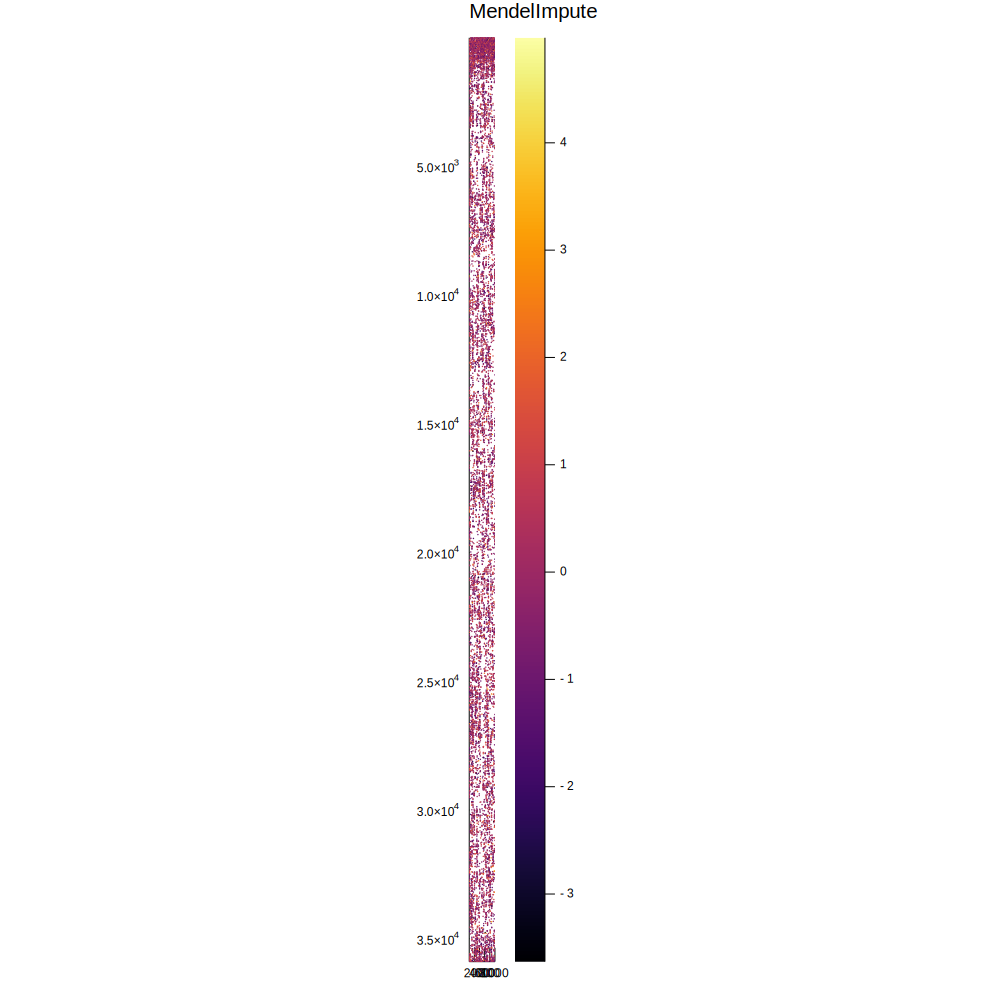

In [75]:
spy(mendel_disagreeing_entries, size=(1000,1000), title="MendelImpute", title_location=:left)

In [76]:
for i in 1:Int(ceil(size(X, 1) / width)) - 1
    println(count(!iszero, mendel_disagreeing_entries[(1 + width * (i - 1)):width * i, :]))
end

2009
408
360
194
238
414
345
240
366
372
275
239
323
255
389
251
218
309
345
280
302
392
425
287
291
314
348
385
324
